# Expected signature of polynomial processes in $(d+1)$-dimensions

> We implement here the formula providing the expecation of the signature of a continuous polynomial process $X$ in $d+1$ dimensions.

In [ ]:
#| default_exp exp_sig

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import math 
import scipy.special
from scipy.linalg import expm, sinm, cosm
import cmath
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm.auto import tqdm
import time
import fractions
from itertools import permutations

## Auxiliary functions

First, we need to define some maps mapping a multiindex to its lexicographic order and back.

In [ ]:
#| export
def fromwordtonum(I,d):
    '''
    Providing the number corresponding to the multiindex I in a vocabulary of words of letters {0,...,d}.
    '''
    if len(I)==0:
        return 0
    powers=np.ones(len(I))
    for i in range(len(I)):
        powers[i]=(d+1)**i
    powers=np.flip(powers)
    all0but1=np.ones(len(I))
    all0but1[-1]=0
    return int(np.dot(I+all0but1,powers))+1

In [ ]:
#| export
def fromnumtoword(n,d):
    '''
    Providing the multiindex corresponding to the number n in a vocabulary of words of letters {0,...,d}.
    '''
    if n==0:
        return []
    else:
        return fromnumtoword((n-1)//(d+1),d)+[(n-1)%(d+1),]

In [ ]:
#| export
def fromlentonum(len_max,d):
    '''
    Providing the maximal component of a vector with all multiindices of lenght<=len_max. 
    '''
    maxword=d*np.ones(len_max)
    return fromwordtonum(maxword,d)

We introduce then the shuffle product and its vectorial representation.

In [ ]:
#| export
def shuffle(a,b):
    '''
    Input:
        a,b: multiindices
    
    Output:
        list of multiindices in a shuffle b
    '''
    sh = []
    if len(a)==0:
        return [b,]
    if len(b)==0:
        return [a,]
    else:
        [sh.append(p+[a[-1],]) for p in shuffle(a[:-1],b)]
        [sh.append(p+[b[-1],]) for p in shuffle(a,b[:-1])]
    return sh

In [ ]:
#| export
def shuffletensor(len_1,len_2,d):
    '''
    Input:
        len_1,len_2: maximal lenght of the input's multiindices
        {0,...,d} denotes the set of indices
    
    Output:
        tensor
    '''
    dim1=fromlentonum(max(len_1,len_2),d)+1
    dim2=fromlentonum(min(len_1,len_2),d)+1
    dim_out=fromlentonum(len_1+len_2,d)+1
    tensor=np.zeros((dim1,dim2,dim_out))
    tensor[0,0,0]=1
    for i in range(1,dim1):
        tensor[i,0,i]=1
        if i<dim2:
            tensor[0,i,i]=1
        for j in range (1,min(i+1,dim2)):
            wordi=fromnumtoword(i,d)
            wordj=fromnumtoword(j,d)
            shufflelist=shuffle(wordi,wordj)
            for word in shufflelist:
                tensor[i,j,fromwordtonum(word,d)]+=1
                if i !=j and i<dim2:
                    tensor[j,i,fromwordtonum(word,d)]+=1
    if len_2>len_1:
        tensor=np.swapaxes(tensor, 0, 1)
    return tensor

## From polynomials to linear combinations of the signature
Recall that for every symmetric matrix $c_2$
\begin{align*}
p(X_t)&=c_0+ c_1^\top X_t+Tr(c_2 X_tX_t^\top)\\
&=(c_0+c_1^\top X_0+ Tr(c_2 X_0X_0^\top))\pi_0(\mathbb X_t)
+(c_1^\top +2X_0^\top c_2 )\pi_1(\mathbb X_t)
+2Tr(c_2 \pi_2(\mathbb X_t)).
\end{align*}
Given $c_0,c_1,c_2$ and $X_0$ the function polytosig returns a vector $csig$ such that
$$csig^\top vec(\mathbb X^{\leq 2})=p(X_t).$$

In [ ]:
#| export
def polytosig(c0,c1,c2,x0):
    '''
    Input:
        c0: float
        c1,c2,x0: array_like
        
        c0,c1,c2 denotes the coefficient of a polynomial parametrized as number, vector, and matrix.
        x0 denotes the initial value of the considered process.
    
    Output:
        np.array
        
        coefficients of the truncated signature in the corresponding representation
    '''
    c2sim=(c2+np.transpose(c2))/2
    csig=c0+np.dot(c1,x0)+np.tensordot(np.tensordot(x0,x0,axes=0),c2sim,axes=([0,1],[0,1]))
    csig=np.concatenate((csig,c1+2*np.dot(x0,c2sim)),axis=None)
    csig=np.concatenate((csig,2*np.squeeze(np.asarray(c2sim))),axis=None)
    return csig

Next, we need to initialize the coefficents. Suppose that the dynamics of a polynomial process $X$ are given by a drift vector
$$b(X_t)^i=b_i+\sum_{j=0}^db_{ij}X_t^j,$$
a diffusion matrix
$$a(X_t)^{ij}=a_{ij}+\sum_{k=0}^da_{ijk}X_t^k+\sum_{k,h=0}^da_{ijkh}X_t^kX_t^h,$$
and an initial condition $x_0$. Set then
\begin{align*}
b_{const}[i]&=b_i,& b_{lin}[i,j]&=b_{ij},\\
a_{const}[i,j]&=a_{ij},& a_{lin}[i,j,k]&=a_{ijk},& a_{quad}[i,j,k,h]=a_{ijkh}.
\end{align*}
The function polytosigvec maps the coefficients $[b_{const},b_{lin},a_{const},a_{lin},a_{quad}]$ and $x_0$ to $[bsig,asig]$ such that
$$bsig[i]^\top vec(\mathbb X^{\leq 2})=b(X_t)^i\qquad\text{and}\qquad asig[i,j]^\top vec(\mathbb X^{\leq 2})=a(X_t)^{ij}.$$

In [ ]:
#| export
def polytosigvec(coeff,x0):
    '''
    Input:
        coeff: list
        x0 : array_like
        
        coeff denotes the list of coefficients [b_{const},b_{lin},a_{const},a_{lin},a_{quad}]
        x0 denotes the initial value of the process
    
    Output: list
        list[0] is an np.array with coefficients of the truncated signature in the representation of b(X)
        list[1] is an np.array with coefficients of the truncated signature in the representation of a(X)
    '''
    b_const=coeff[0]
    b_lin=coeff[1]
    a_const=coeff[2]
    a_lin=coeff[3]
    a_quad=coeff[4]
    
    dim=len(b_const)
    bsig=np.zeros((dim,1+dim+dim**2))
    asig=np.zeros((dim,dim,1+dim+dim**2))
    for i in range(dim):
        bsig[i]=polytosig(b_const[i],b_lin[i,:],np.zeros((dim,dim)),x0)
        for j in range(dim):
            asig[i,j]=polytosig(a_const[i,j],a_lin[i,j,:],a_quad[i,j,:],x0)
    return bsig,asig

## Expected signature of polynomial processes

We are now ready to implement the operator
$$Le_I=e_{I'}\# b^{i_{|I|}}+\frac 1 2 e_{I''}\# a^{i_{|I|-1},i_{|I|}}.$$
In the vectorial representation $L$ can be written as a matrix $matrix(L)$ such that
$$matrix(L) vec(e_I)=vec(Le_I).$$

In [ ]:
#| export
def matrixL(coeff,x0,len_max,dim):
    '''
    Input:
        coeff: list
        x0 : array_like
        len_max,dim: float

        coeff denotes the list of coefficients [b_{const},b_{lin},a_{const},a_{lin},a_{quad}]
        x0 denotes the initial value of the process 
        len_max and dim denote the desired truncation level and the dimension of X, respectively.
        
    Output:
        np.ndarray
        
        the matrix corresponding to the generator of the signature trucated at level len_max of the corresponding process.
    '''
    d=dim-1
    dimL=fromlentonum(len_max,d)+1
    sigcoeff=polytosigvec(coeff,x0)
    shuffletens=shuffletensor(2,len_max-1,d)[:,:,:dimL]
    
    L=np.zeros((dimL))
    for n in tqdm(range(1,dimL)):
        word=fromnumtoword(n,d)
        numprime=fromwordtonum(word[:-1],d)
        L_run=np.tensordot(sigcoeff[0][word[-1]],shuffletens,axes=([-1],[0]))[numprime,:]
        numsecond=fromwordtonum(word[:-2],d)
        if len(word)>1:
            L_run+=1/2*np.tensordot(sigcoeff[1][tuple(word[-2:])],shuffletens,axes=([-1],[0]))[numsecond,:]
        L=np.vstack((L,L_run))
    return L

Resourcing to the polynomial formula we can now compute the expected signature
$\mathbb E[\mathbb X_T^{\leq len_{max}}].$

In [ ]:
#| export
def expsig(coeff,x0,len_max,dim,T):
    '''
    Input:
        coeff: list
        x0 : array_like
        len_max,dim,T: float

        coeff denotes the list of coefficients [b_{const},b_{lin},a_{const},a_{lin},a_{quad}]
        x0 denotes the initial value of the process 
        len_max and dim denote the desired truncation level and the dimension of X, respectively.
        T denotes the time
        
    Output:
        np.array
        
        vector corresponding to E[Sig(X)_T^{len_max}]
    '''
    matL=matrixL(coeff,x0,len_max,dim)
    #print('Shape of the L-matrix',matL.shape)
    return expm(T*matL)[:,0]

To better read the oputput of expsig we also provide a function associating to each non-zero coponent of the expected signature its multiindex. Alternatively, the function expsig_withwords concatenate the two functions.

In [ ]:
#| export
def withwords(Expsig,dim):
    '''
    Input:
        Expsig: array_like
        dim: float

        Expsig denotes the output of the function expsig
        
    Output:
        list
        
        list of non-zero components of the signature together with the corresponding multiindex.
    '''
    d=dim-1
    listofwords=[]
    for n in range(len(Expsig)):
        if Expsig[n]!=0:
            #listofwords+=[[str(fractions.Fraction(Expsig[n]).limit_denominator()),fromnumtoword(n,d)],]
            listofwords+=[[Expsig[n],fromnumtoword(n,d)],]
    return listofwords

In [ ]:
#| export
def expsig_withwords(coeff,x0,len_max,dim,T):
    '''
    Input:
        coeff: list
        x0 : array_like
        len_max,dim,T: float

        coeff denotes the list of coefficients [b_{const},b_{lin},a_{const},a_{lin},a_{quad}]
        x0 denotes the initial value of the process 
        len_max and dim denote the desired truncation level and the dimension of X, respectively.
        T denotes the time
        
    Output:
        list
        
        list of non-zero components of the signature together with the corresponding multiindex.
    '''
    Expsig=expsig(coeff,x0,len_max,dim,T)
    return withwords(Expsig,dim)

In one dimension, one can obtain the moments of a process from the expected signature by means of the simple formula
$$X_t^k=k!\sum_{i=0}^k\frac{X_0^{k-i}}{(k-i)!}\langle e_0^{\otimes i},\mathbb X_t\rangle.$$

In [ ]:
#| export
def moments(coeff,x0,len_max,dim,T):
    Expsig=expsig(coeff,x0,len_max,dim,T)
    powers=np.ones(len(Expsig))
    for k in range(1,len(Expsig)):
        powers[k]=x0[0]**k/math.factorial(k)
    mom=np.ones(len(Expsig))
    for k in range(len(Expsig)):
        mom[k]=math.factorial(k)*np.dot(np.flip(powers[:k+1]),Expsig[:k+1])
    return mom  

## Examples

### Expected signature and moments of a Brownian motion

As a first step we need to introduce the coefficients of the polynomial process.

In [ ]:
dim=1

b_const=np.zeros(dim)
b_lin=np.zeros((dim,dim))
a_const=np.zeros((dim,dim))
a_lin=np.zeros((dim,dim,dim))
a_quad=np.zeros((dim,dim,dim,dim))

a_const[0]=1

coeff=(b_const,b_lin,a_const,a_lin,a_quad)

x0=np.zeros(dim)

len_max=10
T=1

Next, we run the proposed code for the expected signature.

In [ ]:
Expsig=expsig(coeff,x0,len_max,dim,T)

  0%|          | 0/10 [00:00<?, ?it/s]

And finally we obtain a readable output.

In [ ]:
withwords(Expsig,dim)

[[1.0, []],
 [0.5, [0, 0]],
 [0.125, [0, 0, 0, 0]],
 [0.020833333333333332, [0, 0, 0, 0, 0, 0]],
 [0.002604166666666666, [0, 0, 0, 0, 0, 0, 0, 0]],
 [0.00026041666666666655, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

With the apposite code one can also get the corresponding moments.

In [ ]:
moments(coeff,x0,len_max,dim,T)

  0%|          | 0/10 [00:00<?, ?it/s]

array([  1.,   0.,   1.,   0.,   3.,   0.,  15.,   0., 105.,   0., 945.])

### Time extended 2 dimensional Brownian Motion

As a first step we need to introduce the coefficients of the polynomial process.

In [ ]:
dim=3

b_const=np.zeros(dim)
b_lin=np.zeros((dim,dim))
a_const=np.zeros((dim,dim))
a_lin=np.zeros((dim,dim,dim))
a_quad=np.zeros((dim,dim,dim,dim))

b_const[0]=1
a_const[1,1]=1
a_const[2,2]=1

coeff=(b_const,b_lin,a_const,a_lin,a_quad)

x0=np.zeros(dim)

len_max=5
T=1

Finally, we run the proposed code with a readable output.

In [ ]:
expsig_withwords(coeff,x0,len_max,dim,T)

  0%|          | 0/363 [00:00<?, ?it/s]

[[1.0, []],
 [1.0, [0]],
 [0.5, [0, 0]],
 [0.5, [1, 1]],
 [0.5, [2, 2]],
 [0.16666666666666666, [0, 0, 0]],
 [0.25, [0, 1, 1]],
 [0.25, [0, 2, 2]],
 [0.25, [1, 1, 0]],
 [0.25, [2, 2, 0]],
 [0.04166666666666666, [0, 0, 0, 0]],
 [0.08333333333333333, [0, 0, 1, 1]],
 [0.08333333333333333, [0, 0, 2, 2]],
 [0.08333333333333333, [0, 1, 1, 0]],
 [0.08333333333333333, [0, 2, 2, 0]],
 [0.08333333333333333, [1, 1, 0, 0]],
 [0.125, [1, 1, 1, 1]],
 [0.125, [1, 1, 2, 2]],
 [0.08333333333333333, [2, 2, 0, 0]],
 [0.125, [2, 2, 1, 1]],
 [0.125, [2, 2, 2, 2]],
 [0.00833333333333333, [0, 0, 0, 0, 0]],
 [0.02083333333333333, [0, 0, 0, 1, 1]],
 [0.02083333333333333, [0, 0, 0, 2, 2]],
 [0.02083333333333333, [0, 0, 1, 1, 0]],
 [0.02083333333333333, [0, 0, 2, 2, 0]],
 [0.02083333333333333, [0, 1, 1, 0, 0]],
 [0.041666666666666664, [0, 1, 1, 1, 1]],
 [0.041666666666666664, [0, 1, 1, 2, 2]],
 [0.02083333333333333, [0, 2, 2, 0, 0]],
 [0.041666666666666664, [0, 2, 2, 1, 1]],
 [0.041666666666666664, [0, 2, 2, 2, 

### The Jacobi Process

In [ ]:
dim=1

b_const=np.zeros(dim)
b_lin=np.zeros((dim,dim))
a_const=np.zeros((dim,dim))
a_lin=np.zeros((dim,dim,dim))
a_quad=np.zeros((dim,dim,dim,dim))

a_lin[0]=1
a_quad[0]=-1

coeff=(b_const,b_lin,a_const,a_lin,a_quad)

x0=np.zeros(dim)
x0[0]=1/2

len_max=10
T=10000

In [ ]:
#Expsig=
expsig(coeff,x0,len_max,dim,T)
#withwords(Expsig,dim)

  0%|          | 0/10 [00:00<?, ?it/s]

array([1.00000000e+00, 0.00000000e+00, 1.25000000e-01, 0.00000000e+00,
       2.60416667e-03, 0.00000000e+00, 2.17013889e-05, 0.00000000e+00,
       9.68812004e-08, 0.00000000e+00, 2.69114446e-10])

In [ ]:
len_max=20

Moments=moments(coeff,x0,len_max,dim,T)

  0%|          | 0/20 [00:00<?, ?it/s]

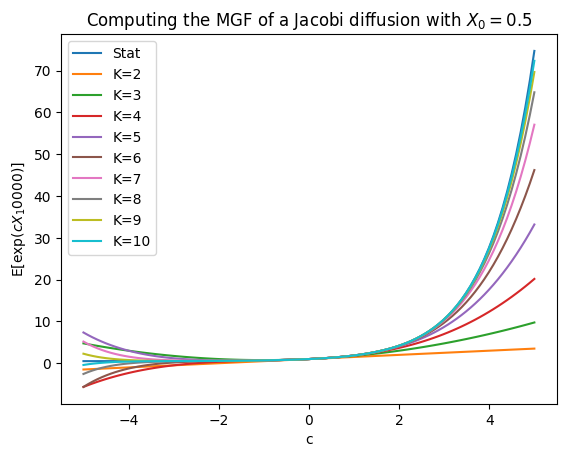

In [ ]:
def expc(c):
    u=np.ones(len(Moments))
    for k in range(len(u)):
        u[k]=c**k/math.factorial(k)
    return u

space=np.linspace(-5,5,100)

stationary=1/2*(1+np.exp(space))

plt.plot(space,stationary,label=f'Stat'); 

for j in range(2,11,1):
    MGF=np.ones(len(space))
    for k in range(len(MGF)):
        MGF[k]=np.dot(expc(space[k])[:j],Moments[:j])
    plt.plot(space,MGF,label=f'K={j}');    


plt.xlabel("c")
plt.ylabel(f'E[exp($cX_{T}$)]')
plt.title(f'Computing the MGF of a Jacobi diffusion with $X_0=${x0[0]}')
plt.legend();

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()